# KKBOX Churn Prediction

*Arabella Specker, Farouq El-Abbass, Fynn Oldenburg, Kevin Nguyen & Vaclav Pasek (Machine Learning 2487-2122_S2)*

------------------------------------------------------------------------------------------------------------------------

For our project we will follow a pipeline workflow as introduced in class. The initial joining of our available data files and some feature aggregation has already been conducted externally in the file ../kkbox_data_understanding.ipynb due to the size of the data files. The output of that file is the raw churn data on customer granularity which we will use as input for our machine learning pipeline in this file.

<img alt="alt text" src="media/pipeline_workflow.png" width="900"/>

In [17]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder

## 1. Data Processing

------------------------------------------------------------------------------------------------------------------------

In [3]:
# Path to folder containing data file
path = "/Users/fynn/Desktop/ML/KKBOX-Data/"

# Import raw data
kkbox_df = pd.read_csv(path + "kkbox_churn.csv")

kkbox_df.describe()

,is_churn,city,bd,registered_via,registration_init_time,count_userlogs_last_month,num_25_last_month,num_50_last_month,num_75_last_month,num_985_last_month,...,num_985_last_week,num_100_last_week,num_unq_last_week,total_secs_last_week,avg_payment_plan_days,avg_plan_list_price,avg_actual_amount_paid,last_payment_method_id,last_is_auto_renew,memberdays_left
count,970960.000000,860967.000000,860967.000000,860967.000000,8.609670e+05,754551.000000,754551.000000,754551.000000,754551.000000,754551.000000,...,667498.000000,667498.000000,667498.000000,6.674980e+05,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000,933578.000000
mean,0.089942,5.937295,13.583854,6.892744,2.013265e+07,17.935095,108.773786,26.257260,16.545723,18.713420,...,5.459781,152.540436,147.539888,3.993535e+04,33.668171,144.078964,143.761684,38.899789,0.912113,332.568452
std,0.286099,6.441203,20.064040,1.937794,3.011174e+04,9.676949,179.003032,38.707599,22.399375,41.691069,...,12.573304,210.558298,167.310346,5.134569e+04,31.539039,133.629682,133.723976,3.785421,0.283130,2003.127209
min,0.000000,1.000000,-3152.000000,3.000000,2.004033e+07,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,3.400000e-02,0.000000,0.000000,0.000000,3.000000,0.000000,-74.000000
25%,0.000000,1.000000,0.000000,7.000000,2.012021e+07,9.000000,19.000000,5.000000,3.000000,3.000000,...,1.000000,32.000000,38.000000,9.159578e+03,30.000000,99.000000,99.000000,38.000000,1.000000,99.000000
50%,0.000000,1.000000,0.000000,7.000000,2.014060e+07,19.000000,55.000000,14.000000,10.000000,10.000000,...,3.000000,87.000000,96.000000,2.386404e+04,30.000000,149.000000,149.000000,41.000000,1.000000,100.000000
75%,0.000000,13.000000,27.000000,9.000000,2.016012e+07,27.000000,133.000000,33.000000,22.000000,23.000000,...,7.000000,188.000000,196.000000,5.018832e+04,30.000000,149.000000,149.000000,41.000000,1.000000,100.000000
max,1.000000,22.000000,2016.000000,13.000000,2.017042e+07,31.000000,46820.000000,3163.000000,1310.000000,15164.000000,...,4048.000000,16884.000000,4292.000000,4.196711e+06,450.000000,2000.000000,2000.000000,41.000000,1.000000,79281.000000


## 1.1. Missing Values

In [4]:
# Get counts of missing values
print(kkbox_df.isna().sum())

# Get number of rows if we would remove all NaN
print("\nNumber of rows when removing all NaN:", len(kkbox_df.dropna().index))

# Get number of rows if we would remove all NaN after dropping gender
print("\nNumber of rows when removing all NaN without gender:",
      len(kkbox_df.drop("gender", axis=1).dropna().index))

msno                              0
is_churn                          0
city                         109993
bd                           109993
gender                       582055
registered_via               109993
registration_init_time       109993
count_userlogs_last_month    216409
num_25_last_month            216409
num_50_last_month            216409
num_75_last_month            216409
num_985_last_month           216409
num_100_last_month           216409
num_unq_last_month           216409
total_secs_last_month        216409
num_25_last_week             303462
num_50_last_week             303462
num_75_last_week             303462
num_985_last_week            303462
num_100_last_week            303462
num_unq_last_week            303462
total_secs_last_week         303462
avg_payment_plan_days         37382
avg_plan_list_price           37382
avg_actual_amount_paid        37382
last_payment_method_id        37382
last_is_auto_renew            37382
memberdays_left             

Some features have large amounts of missing values. Especially gender is missing data for almost two thirds of the instances. If we would remove all instances with any missing value we would end up with a data set size of 319.988 rows out of 970.960 rows in the beginning. We assume that gender should not have a significant predictive effect on the customer churn rate and exclude it in order to preserve 336.447 additional instances.

We can preserve another 168.933 instances by looking in detail at the features extracted from the user activity log per month (..._last_month) and week (..._last_week). We can assume that the customers who have values for the "last month" features but no values for the "last week" features did not have any activity in the last week. Furthermore, if a customer has only missing values for the month and the week features this means that there are no user logs available for the last month. Consequently, instead of just dropping the customers with missing user log information, we can **replace the missing values by 0** indicating no user activity in the last month or week.

In [5]:
# Drop gender to preserve 336.447 rows
kkbox_df_clean = kkbox_df.drop("gender", axis=1)

# Fill missing values indicating no customer activity with zeros to preserve 168.933 rows
month_week_cols = kkbox_df_clean.filter(regex="month|week").columns
kkbox_df_clean[month_week_cols] = kkbox_df_clean[month_week_cols].fillna(0)

# Drop rows with missing values
kkbox_df_clean = kkbox_df_clean.dropna()

print("Size of NA cleaned dataset:", len(kkbox_df_clean.index))

Size of NA cleaned dataset: 825368


## 1.2. Handle Categorical Variables

In [6]:
# HANDLE FEATURE TYPES ---------------------------------------------------------

# Round all features
kkbox_df_clean.iloc[:,2:] = round(kkbox_df_clean.iloc[:,2:]).astype("int64")


# HANDLE CATEGORICAL FEATURES --------------------------------------------------

# Set correct types of categorical variables
cat_feats = ["city", "registered_via", "last_payment_method_id"]
kkbox_df_clean[cat_feats] = kkbox_df_clean[cat_feats].astype("category")

# One-hot encoding
encoder = OneHotEncoder(sparse=False)
cat_feats_onehot = encoder.fit_transform(kkbox_df_clean[cat_feats])
df_cat_feats_onehot = pd.DataFrame(cat_feats_onehot).astype("int64")
df_cat_feats_onehot.columns = encoder.get_feature_names(cat_feats)

# Append one-hot encoded features to data frame
kkbox_df_clean = pd.concat([kkbox_df_clean.reset_index(), df_cat_feats_onehot], axis=1)

# Remove not needed columns
kkbox_df_clean = kkbox_df_clean.drop(["index", "msno"] + cat_feats, axis=1)
kkbox_df_clean

,is_churn,bd,registration_init_time,count_userlogs_last_month,num_25_last_month,num_50_last_month,num_75_last_month,num_985_last_month,num_100_last_month,num_unq_last_month,...,last_payment_method_id_32,last_payment_method_id_33,last_payment_method_id_34,last_payment_method_id_35,last_payment_method_id_36,last_payment_method_id_37,last_payment_method_id_38,last_payment_method_id_39,last_payment_method_id_40,last_payment_method_id_41
0,1,20,20131223,6,0,4,2,0,26,30,...,0,0,0,0,1,0,0,0,0,0
1,1,18,20131227,20,239,57,32,22,205,432,...,0,0,0,0,0,0,0,0,0,0
2,1,0,20140109,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,35,20140125,15,9,7,4,4,962,548,...,0,0,0,0,0,0,0,0,0,1
4,1,0,20140126,4,6,1,1,4,37,48,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825363,0,25,20110830,24,117,26,30,25,461,429,...,0,0,0,0,0,0,0,0,0,1
825364,0,28,20110831,24,48,7,4,9,318,291,...,0,0,0,0,0,0,0,0,1,0
825365,0,0,20110903,5,43,8,8,7,22,54,...,0,0,0,0,0,0,0,0,0,1
825366,0,0,20110905,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 2. Feature Scaling & Selection

------------------------------------------------------------------------------------------------------------------------

In [12]:
# Split data
kkbox_X = kkbox_df_clean.drop("is_churn", axis=1)
kkbox_y = kkbox_df_clean["is_churn"]

## 2.1 Dimensionality Reduction

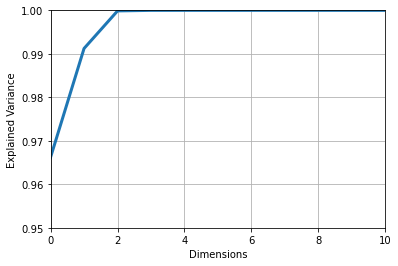

In [24]:
from sklearn.decomposition import PCA

# Find the best number of features to preserve 95% of variance
pca = PCA()
pca.fit(kkbox_X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

# Plot elbow curve
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 10, 0.95, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.grid(True)
plt.show()


In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
kkbox_X_scaled = scaler.fit_transform(kkbox_X)

kkbox_X_scaled

array([[ 0.32503939, -0.04093512, -0.92459389, ..., -0.2900598 ,
        -0.31181443, -1.07931307],
       [ 0.2260534 , -0.04080267,  0.37065563, ..., -0.2900598 ,
        -0.31181443, -1.07931307],
       [-0.66482045,  0.25330765, -1.47970083, ..., -0.2900598 ,
        -0.31181443,  0.92651523],
       ...,
       [-0.66482045, -0.71379277, -1.01711171, ..., -0.2900598 ,
        -0.31181443,  0.92651523],
       [-0.66482045, -0.71372655, -1.47970083, ..., -0.2900598 ,
        -0.31181443,  0.92651523],
       [ 0.57250434, -0.71372655,  0.6482091 , ...,  3.44756494,
        -0.31181443, -1.07931307]])

## 2. Modeling

------------------------------------------------------------------------------------------------------------------------

## 2.1. Decision Tree Classifier

In [77]:
# Split data
X = kkbox_df_clean.drop("is_churn", axis=1)
y = kkbox_df_clean["is_churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree model
clf = DecisionTreeClassifier(max_depth =3, random_state = 42)
clf.fit(X_train, y_train)

# Predict test data
y_test_pred = clf.predict(X_test)

# Export decision rules
tree_rules = export_text(clf, feature_names = list(X.columns))
print(tree_rules)

|--- memberdays_left <= 200.50
|   |--- memberdays_left <= 26.50
|   |   |--- total_secs_last_week <= 913.00
|   |   |   |--- class: 1
|   |   |--- total_secs_last_week >  913.00
|   |   |   |--- class: 0
|   |--- memberdays_left >  26.50
|   |   |--- avg_actual_amount_paid <= 16.50
|   |   |   |--- class: 1
|   |   |--- avg_actual_amount_paid >  16.50
|   |   |   |--- class: 0
|--- memberdays_left >  200.50
|   |--- memberdays_left <= 19199.50
|   |   |--- memberdays_left <= 202.50
|   |   |   |--- class: 0
|   |   |--- memberdays_left >  202.50
|   |   |   |--- class: 1
|   |--- memberdays_left >  19199.50
|   |   |--- count_userlogs_last_month <= 0.50
|   |   |   |--- class: 1
|   |   |--- count_userlogs_last_month >  0.50
|   |   |   |--- class: 0



## 3. Model Evaluation

------------------------------------------------------------------------------------------------------------------------

In [75]:
accuracy = metrics.accuracy_score(y_test, y_test_pred)
print("Accuracy score: ", accuracy)

recall = metrics.recall_score(y_test, y_test_pred)
print("Recall score:   ", recall)

precision = metrics.precision_score(y_test, y_test_pred)
print("Precision score:", precision)

Accuracy score:  0.9726304566436871
Recall score:    0.6273888319194556
Precision score: 0.92814784167701


Even a simple Decision Tree model without much preprocessing (no numerical feature scaling, feature selection or dimensionality reduction) results in accuracy of 0.97.